## SHAP values

<img src="https://cacm.acm.org/wp-content/uploads/2024/06/061724.RE_.Explainability-Is-Not.jpg?resize=2048,1152" width=350>

[***Explainability is Not a Game***](https://cacm.acm.org/research/explainability-is-not-a-game/)  
*By Joao Marques-Silva and Xuanxiang Huang*
> When the decisions of ML models impact people, one should expect explanations to offer the strongest guarantees of rigor. However, the most popular XAI approaches offer none.

In this notebook we try to replicate some of the analyses from the paper. The input data is boolean and we're assessing the plausibility of SHAP values.

Author: https://www.github.com/deburky

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values for instance 0 (KernelExplainer):
  Feature  SHAP Value
0      X1   -0.249012
1      X2    0.131104
2      X3    0.000000
3      X4    0.000000


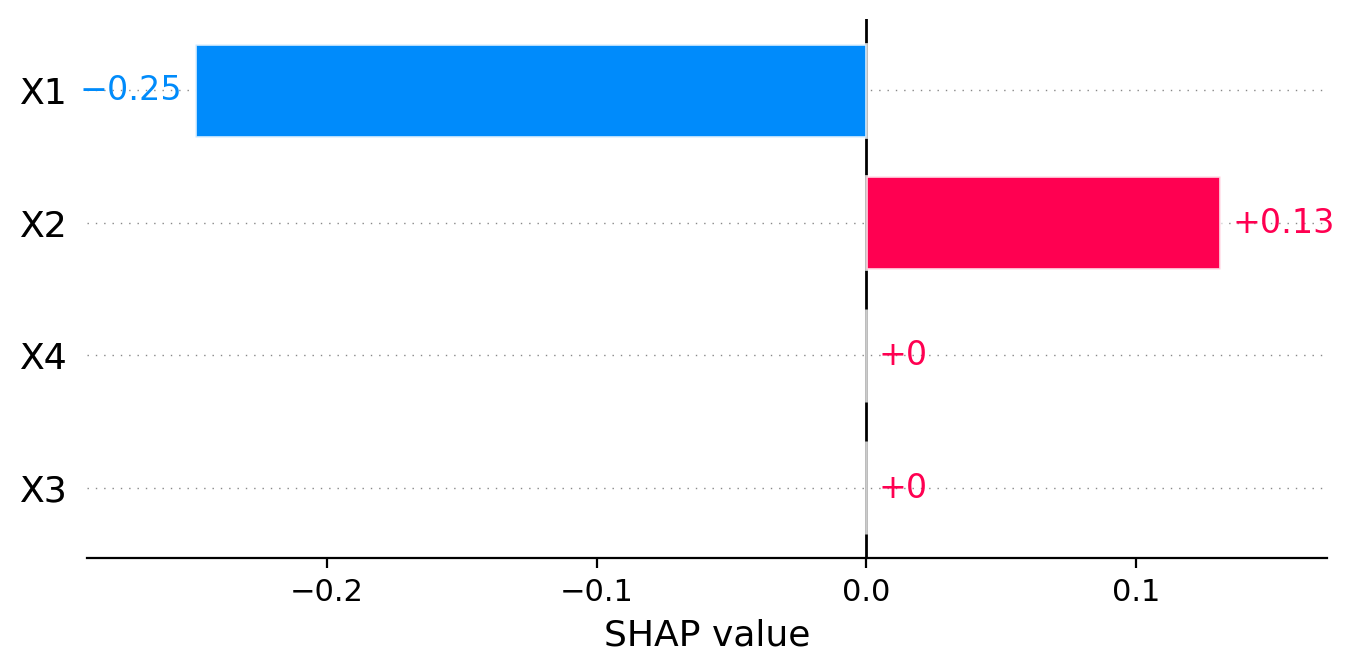

In [3]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Generate synthetic binary data
np.random.seed(42)
n_samples = 1000
X = pd.DataFrame(
    {
        "X1": np.random.randint(0, 2, size=n_samples),
        "X2": np.random.randint(0, 2, size=n_samples),
        "X3": np.random.randint(0, 2, size=n_samples),
        "X4": np.random.randint(0, 2, size=n_samples),
    }
)
y = (X["X1"] & X["X2"]).astype(int)

# Train XGBoost model
model = xgb.XGBClassifier(n_estimators=10, max_depth=1, eval_metric="logloss")
model.fit(X, y)

# Pick the instance to explain
instance = X.iloc[[0]]


# KernelExplainer (model-agnostic)
def predict_fn(x):
    return model.predict_proba(x)[:, 1]  # probability for class 1


# Background dataset
background = X.copy()

explainer = shap.KernelExplainer(predict_fn, background)

# Compute SHAP values for one instance
shap_values = explainer.shap_values(instance)

# Organize output
shap_result = pd.DataFrame(
    {"Feature": X.columns, "SHAP Value": shap_values[0]}
).sort_values(by="SHAP Value", key=abs, ascending=False)

print("SHAP values for instance 0 (KernelExplainer):")
print(shap_result)

plt.figure(figsize=(8, 3))
shap.plots.bar(
    shap.Explanation(values=shap_values[0], feature_names=X.columns.to_list()),
    show=False,
)
plt.show()

## 🧮 Manual SHAP

In [6]:
import itertools
import math

import pandas as pd
from tqdm.notebook import tqdm

instance = X.iloc[0]
features = list(X.columns)
instance_dict = instance.to_dict()

shap_values = {}

for f in tqdm(features):
    others = [x for x in features if x != f]
    contrib = 0

    for r in range(len(others) + 1):
        for S in itertools.combinations(others, r):
            S = set(S)
            S_with_f = S | {f}

            # Shapley weight
            weight = (
                math.factorial(len(S))
                * math.factorial(len(features) - len(S) - 1)
                / math.factorial(len(features))
            )

            # Estimate E[f(x) | S]
            values_without_f = []
            for _, row in X.iterrows():
                test_row = row.copy()
                for s in S:
                    test_row[s] = instance_dict[s]
                values_without_f.append(
                    model.predict_proba(pd.DataFrame([test_row]))[0, 1]
                )
            E_without_f = sum(values_without_f) / len(values_without_f)

            # Estimate E[f(x) | S ∪ {f}]
            values_with_f = []
            for _, row in X.iterrows():
                test_row = row.copy()
                for s in S_with_f:
                    test_row[s] = instance_dict[s]
                values_with_f.append(
                    model.predict_proba(pd.DataFrame([test_row]))[0, 1]
                )
            E_with_f = sum(values_with_f) / len(values_with_f)

            # Marginal contribution of f in context S
            contrib += weight * (E_with_f - E_without_f)

    shap_values[f] = contrib  # Calculate SHAP values

  0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
print("Manual SHAP values:")
for feat, val in sorted(shap_values.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feat}: {val:.6f}")

print("\nKernelExplainer SHAP:")
for _, row in shap_result.iterrows():
    print(f"{row['Feature']}: {row['SHAP Value']:.6f}")

Manual SHAP values:
X1: -0.249012
X2: 0.131104
X3: 0.000000
X4: 0.000000

KernelExplainer SHAP:
X1: -0.249012
X2: 0.131104
X3: 0.000000
X4: 0.000000


## Single-factor SHAP

To compute the SHAP value for X₂, we consider **all possible subsets** of the other features (X₁, X₃, X₄). For each subset, we evaluate how much **adding X₂** to that subset changes the model’s prediction.

Each row below represents:
- A context where a subset of features is already known (`subset`)
- And the same context with X2 added (`subset+f`)

This setup allows us to isolate the **marginal contribution of X₂** in every possible scenario.

> For n total features, we have $2^{n - 1}$ rows (subset combinations) to evaluate for each feature's SHAP value, because we exclude the feature being explained and consider all subsets of the rest (in this case we have 8).

| index | subset              | subset+f                    |
|-------|---------------------|-----------------------------|
| 0     | []                  | ['X2']                      |
| 1     | ['X1']              | ['X1', 'X2']                |
| 2     | ['X3']              | ['X3', 'X2']                |
| 3     | ['X4']              | ['X4', 'X2']                |
| 4     | ['X1', 'X3']        | ['X1', 'X3', 'X2']          |
| 5     | ['X1', 'X4']        | ['X1', 'X4', 'X2']          |
| 6     | ['X3', 'X4']        | ['X3', 'X4', 'X2']          |
| 7     | ['X1', 'X3', 'X4']  | ['X1', 'X3', 'X4', 'X2']    |

In each of these cases:

- The model prediction is computed once using just the subset (with X₂ left to vary),
- Then again with X₂ added and fixed to the instance value.
- The **difference** in those predictions is the **effect of X₂ in that context**.

Finally, all these effects are **averaged** (using Shapley weights) to give the overall SHAP value for X₂.

This process guarantees that X₂ is evaluated **fairly across all possible combinations** of features it might interact with.

In [11]:
import itertools
from math import factorial

import numpy as np
import pandas as pd

# Assume model and X are defined already
instance = X.iloc[0]
instance_dict = instance.to_dict()
feature_to_explain = "X2"
features = list(X.columns)
other_features = [f for f in features if f != feature_to_explain]

shap_value = 0
records = []  # Store contributions from each subset


def shap_weight(s, n):
    """SHAP weights."""
    return factorial(len(s)) * factorial(n - len(s) - 1) / factorial(n)


for subset in itertools.chain.from_iterable(
    itertools.combinations(other_features, r) for r in range(len(other_features) + 1)
):  # Get possible subsets
    subset = list(subset)  # Convert subset to list
    weight = shap_weight(subset, len(features))  # Calculate SHAP weight

    preds_without_f = []  # Predictions without feature of interest
    preds_with_f = []  # Predictions with feature of interest

    for _, row in tqdm(X.iterrows(), desc="Calculating SHAP values", total=len(X)):
        # Without f: fix only features in subset
        row_without_f = row.copy()
        row_without_f.update(
            {k: instance_dict[k] for k in subset}
        )  # Replace values from instance dict
        pred_without_f = model.predict_proba(pd.DataFrame([row_without_f]))[
            0, 1
        ]  # Make inference (class 1 membership probability)
        preds_without_f.append(pred_without_f)

        # With f: fix both the subset and f
        row_with_f = row.copy()
        subset_with_f = [*subset, feature_to_explain]
        row_with_f.update(
            {k: instance_dict[k] for k in subset_with_f}
        )  # Replace values from instance dict

        pred_with_f = model.predict_proba(pd.DataFrame([row_with_f]))[
            0, 1
        ]  # Make inference (class 1 membership probability)
        preds_with_f.append(pred_with_f)

    E_without_f = np.mean(preds_without_f)
    E_with_f = np.mean(preds_with_f)
    delta = E_with_f - E_without_f
    shap_value += weight * delta

    # Store for later analysis
    records.append(
        {
            "subset": subset,
            "subset+f": [*subset, feature_to_explain],
            "E_without_f": E_without_f,
            "E_with_f": E_with_f,
            "delta": delta,
            "weight": weight,
            "weighted_delta": weight * delta,
        }
    )

# Convert to DataFrame for analysis
results_df = pd.DataFrame(records)

# Print SHAP value and show table
print(f"\nSHAP value for feature '{feature_to_explain}': {shap_value:.4f}")

Calculating SHAP values:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating SHAP values:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating SHAP values:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating SHAP values:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating SHAP values:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating SHAP values:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating SHAP values:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating SHAP values:   0%|          | 0/1000 [00:00<?, ?it/s]


SHAP value for feature 'X2': 0.1311


In [12]:
display(instance_dict, results_df)
print(results_df["weighted_delta"].sum())
print(results_df["weight"].sum())

{'X1': 0, 'X2': 1, 'X3': 0, 'X4': 1}

,subset,subset+f,E_without_f,E_with_f,delta,weight,weighted_delta
0,[],[X2],0.250260,0.446951,0.196692,0.250000,0.049173
1,[X1],"[X1, X2]",0.066835,0.132351,0.065516,0.083333,0.005460
2,[X3],"[X3, X2]",0.250260,0.446951,0.196692,0.083333,0.016391
3,[X4],"[X4, X2]",0.250260,0.446951,0.196692,0.083333,0.016391
4,"[X1, X3]","[X1, X3, X2]",0.066835,0.132351,0.065516,0.083333,0.005460
5,"[X1, X4]","[X1, X4, X2]",0.066835,0.132351,0.065516,0.083333,0.005460
6,"[X3, X4]","[X3, X4, X2]",0.250260,0.446951,0.196692,0.083333,0.016391
7,"[X1, X3, X4]","[X1, X3, X4, X2]",0.066835,0.132351,0.065516,0.250000,0.016379


0.13110365718603134
1.0


| index | subset              | subset+f                    |
|-------|---------------------|-----------------------------|
| 5     | ['X1', 'X4']        | ['X1', 'X4', 'X2']          |

We’re explaining X₂:

- *`E_without_f`*: Fix X₁ and X₄ to instance values; let X₂, X₃ vary.
- *`E_with_f`*: Also fix X₂; now only X₃ varies.

---
**What are the SHAP weights?**

*Row 0:*  
- *Subset:* [] (empty)  
- *Subset size:* $|S| = 0$

$$w(S) = \frac{0! \cdot (4 - 0 - 1)!}{4!} = \frac{1 \cdot 6}{24} = 0.25$$

*Row 7:** 
- *Subset:* [X₁, X₃, X₄] 
- *Subset size:* $|S| = 3$

$$w(S) = \frac{3! \cdot (4 - 3 - 1)!}{4!} = \frac{6 \cdot 1}{24} = 0.25$$

## "Explainability is Not a Game" problem setup

> “Shapley values are calculated based on the structure of the model, and not necessarily on the causal or logical relevance of the features.”  
> — *Explainability is Not a Game*, Section 3.1

> “SHAP values may attribute **importance to features that are not logically required**, and may assign **zero importance to features that are logically essential**.”  
> — *Explainability is Not a Game*, Section 3.2

We consider a case from this paper:

* X₁ is not sufficient alone to determine the prediction
* The true logic requires both X₁ = 1 and X₂ = 1 to make y = 1
* So both X₁ and X₂ should be relevant for the prediction y = 0

But SHAP gave all the credit (blame) to X₁, and none to X₂.

In [13]:
import itertools

import pandas as pd
import shap
import xgboost as xgb

# 1. Generate full boolean input space (2^4 = 16 combinations)
X = pd.DataFrame(itertools.product([0, 1], repeat=4), columns=["X1", "X2", "X3", "X4"])

# 2. Define target: y = X1 AND X2
y = (X["X1"] & X["X2"]).astype(int)

# 3. Train a shallow tree model
model = xgb.XGBClassifier(
    n_estimators=1,
    max_depth=2,
    eval_metric="logloss",
)
model.fit(X, y)

# 4. Pick instance to explain
instance = pd.DataFrame([[0, 0, 0, 0]], columns=X.columns)

# 5. Use TreeExplainer (this is where issues appear)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(instance)

# 6. Display results
shap_df = pd.DataFrame(
    {"Feature": X.columns, "SHAP Value": shap_values[0]}
).sort_values(by="SHAP Value", key=abs, ascending=False)

print("SHAP values for instance (0, 0, 0, 0):")
print(shap_df)


SHAP values for instance (0, 0, 0, 0):
  Feature  SHAP Value
0      X1       -0.24
1      X2        0.00
2      X3        0.00
3      X4        0.00


```python
print(model.get_booster().get_dump()[0])
```
```plain
0:[X1<1] yes=1,no=2,missing=2
	1:leaf=-0.250868887
	2:leaf=0.215531722
```

---
This is an example of the "faithfulness vs correctness" tradeoff:

* TreeSHAP explains what the model does
* But what the model does might be causally wrong or logically incomplete

SHAP is mathematically fair given the model, but if the model fails to use important features, SHAP will amplify that mistake in its attributions.

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP values for instance 0 (KernelExplainer):
  Feature  SHAP Value
0      X1   -0.044946
1      X2    0.000000
2      X3    0.000000
3      X4    0.000000


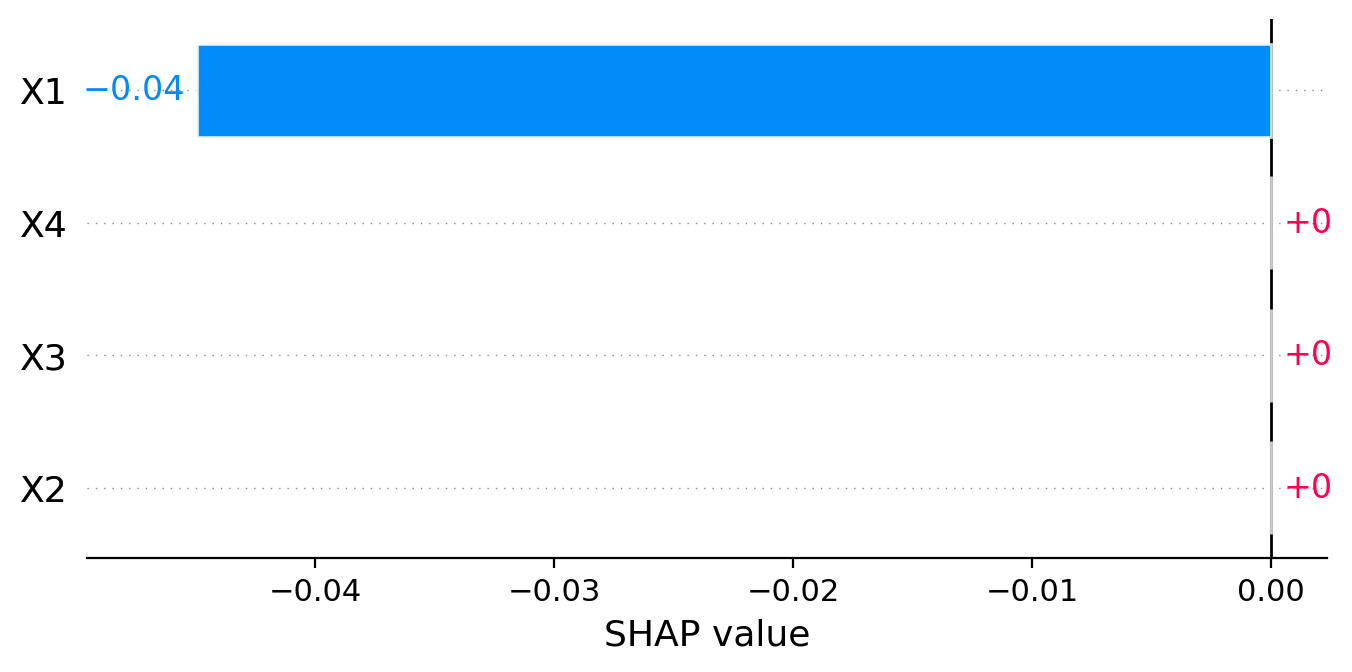

In [15]:
# KernelExplainer (model-agnostic)
def predict_fn(x):
    return model.predict_proba(x)[:, 1]  # probability for class 1


# Background dataset
background = X.copy()
explainer = shap.KernelExplainer(predict_fn, background)
shap_values = explainer.shap_values(instance)

# Organize output
shap_result = pd.DataFrame(
    {"Feature": X.columns, "SHAP Value": shap_values[0]}
).sort_values(by="SHAP Value", key=abs, ascending=False)

print("SHAP values for instance 0 (KernelExplainer):")
print(shap_result)

plt.figure(figsize=(8, 3))
shap.plots.bar(
    shap.Explanation(values=shap_values[0], feature_names=X.columns.to_list()),
    show=False,
)
plt.show()

## Bonus: Stack overflow example with `iml`

The Shapley value ($\phi_i$) represents the contribution of each respective variable towards the predicted valued compared to the average prediction for the data set.

`iml` implements an approximate Shapley estimation algorithm that follows the following steps:

```python
ob = single observation of interest
1: for variables j in {1,...,p} do
     | m = random sample from data set
     | t = rbind(m, ob)
     | f(all) = compute predictions for t
     | f(!j) = compute predictions for t with feature j values randomized
     | diff = sum(f(all) - f(!j))
     | phi = mean(diff)
   end
2. sort phi in decreasing order
```

* [How to calculate SHAP for a factor in a linear model?](https://stats.stackexchange.com/questions/568239/how-to-calculate-shap-for-a-factor-in-a-linear-model)
* [Interpreting Machine Learning Models with the iml Package](https://uc-r.github.io/iml-pkg)

In [16]:
import numpy as np
import pandas as pd
import shap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

# 1. Load dataset
data = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/datasets/ToothGrowth.csv"
)

# 2. Handle categorical variable correctly
encoder = OneHotEncoder(
    drop="first", sparse_output=False
)  # Drop first category to match R (i.e., suppVC)
encoded_supp = encoder.fit_transform(data[["supp"]])

# Replace supp column with one-hot encoding
X = np.hstack([encoded_supp, data[["dose"]].values])
X = pd.DataFrame(X, columns=["suppVC", "dose"])  # Rename to match R variable

y = data["len"]

# 3. Train a linear regression model
mod_lm = LinearRegression()
mod_lm.fit(X, y)

# 4. Compute SHAP values using KernelExplainer (equivalent to R `iml::Shapley`)
explainer = shap.KernelExplainer(mod_lm.predict, X)
shap_values = explainer.shap_values(X)

# 5. Store SHAP values in a DataFrame
shap_df = pd.DataFrame(
    {
        "feature": X.columns,
        "phi": shap_values.min(axis=0),
        "phi_var": shap_values.var(axis=0),
        "feature_value": X.mean(),
    }
)

# Compute SHAP only for row interest
shap_values_int = explainer.shap_values(X.iloc[0, :])
shap_df_int = pd.DataFrame(
    {
        "feature": X.columns,
        "phi": shap_values_int,
        "phi_var": shap_values.var(axis=0),
        "feature_value": X.iloc[0, :],
    }
)

print(shap_df_int)

# Head of results:
# feature       phi   phi.var feature.value
# 1    supp -1.848816  3.422533       supp=VC
# 2    dose -6.489162 37.185843      dose=0.5
# 6. Verify R's SHAP computation for `supp`

supp_effect = (1 - np.mean(data["supp"] == "VC")) * mod_lm.coef_[0]
print(f"SuppVC Effect (should match R's -1.85): {supp_effect:.2f}")

  0%|          | 0/60 [00:00<?, ?it/s]

       feature       phi    phi_var  feature_value
suppVC  suppVC -1.850000   3.422500            1.0
dose      dose -6.509048  37.071738            0.5
SuppVC Effect (should match R's -1.85): -1.85
